<a href="https://colab.research.google.com/github/snamingit/spnamingit/blob/main/Kaggle_Exercise_Age_Conditions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Age-Related Disease Prediction

The goal of this project is to predict whether the variable 'Class' will have a value of:

*   1 :  a person will have any age-related diseases or
*   0 :  a person will NOT have any age-related diseases

This is a binary classification problem.

In [ ]:
# Install packages and import libraries
import tensorflow as tf
import pandas as pd
import xgboost as xgb
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

from datetime import datetime
import warnings
warnings.filterwarnings("ignore")

from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_predict, StratifiedKFold

from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score

#from kerastuner import HyperModel
#from kerastuner.tuners import RandomSearch
#from tensorflow_decision_forests.keras import RandomForestModel

from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE


from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier


!pip install catboost
!pip install tabpfn

from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from tabpfn import TabPFNClassifier
from sklearn.neural_network import MLPClassifier


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 156.6/156.6 kB 2.1 MB/s eta 0:00:00


# Exploratory Data Analysis (EDA) and Data Pre-Processing

The following datasets were used for this project:

1.   Train data: The features are anonymized which limits the use of domain expertise to analyze the data.
2.   Greeks data (supplemental data): This is linked to the Train Dataset

These were provided by InVitro Cell Research, LLC (ICR) for a [Kaggle competition](https://www.kaggle.com/competitions/icr-identify-age-related-conditions).

Test data is not available (hidden in the competition). Hence, for the purpose of this excercise, I extracted a portion of the train dataset for testing.

###### Train dataset

In [ ]:
# Loading the train dataset
df = pd.read_csv('train.csv')

In [ ]:
df.head()

,Id,AB,AF,AH,AM,AR,AX,AY,AZ,BC,...,FL,FR,FS,GB,GE,GF,GH,GI,GL,Class
0,000ff2bfdfe9,0.209377,3109.03329,85.200147,22.394407,8.138688,0.699861,0.025578,9.812214,5.555634,...,7.298162,1.73855,0.094822,11.339138,72.611063,2003.810319,22.136229,69.834944,0.120343,1
1,007255e47698,0.145282,978.76416,85.200147,36.968889,8.138688,3.632190,0.025578,13.517790,1.229900,...,0.173229,0.49706,0.568932,9.292698,72.611063,27981.562750,29.135430,32.131996,21.978000,0
2,013f2bd269f5,0.470030,2635.10654,85.200147,32.360553,8.138688,6.732840,0.025578,12.824570,1.229900,...,7.709560,0.97556,1.198821,37.077772,88.609437,13676.957810,28.022851,35.192676,0.196941,0
3,043ac50845d5,0.252107,3819.65177,120.201618,77.112203,8.138688,3.685344,0.025578,11.053708,1.229900,...,6.122162,0.49706,0.284466,18.529584,82.416803,2094.262452,39.948656,90.493248,0.155829,0
4,044fb8a146ec,0.380297,3733.04844,85.200147,14.103738,8.138688,3.942255,0.054810,3.396778,102.151980,...,8.153058,48.50134,0.121914,16.408728,146.109943,8524.370502,45.381316,36.262628,0.096614,1


In [ ]:
# Checking the number of rows and columns of the dataset
df.shape

(617, 58)


There are 617 rows and 58 columns. There is 1 ID column, 1 target column named 'Class' and  56 features which are all health characteristics related to age-linked diseases.


In [ ]:
# Drop ID variable since this is not informative.
df= df.drop(['Id'], axis=1)

In [ ]:
# Find the data type of each column
df.dtypes

AB       float64
AF       float64
AH       float64
AM       float64
AR       float64
AX       float64
AY       float64
AZ       float64
BC       float64
BD       float64
BN       float64
BP       float64
BQ       float64
BR       float64
BZ       float64
CB       float64
CC       float64
CD       float64
CF       float64
CH       float64
CL       float64
CR       float64
CS       float64
CU       float64
CW       float64
DA       float64
DE       float64
DF       float64
DH       float64
DI       float64
DL       float64
DN       float64
DU       float64
DV       float64
DY       float64
EB       float64
EE       float64
EG       float64
EH       float64
EJ        object
EL       float64
EP       float64
EU       float64
FC       float64
FD       float64
FE       float64
FI       float64
FL       float64
FR       float64
FS       float64
GB       float64
GE       float64
GF       float64
GH       float64
GI       float64
GL       float64
Class      int64
dtype: object

 All but 1 ('EJ') is numerical.

In [ ]:
# Ensure that column EJ is of numerical type
df['EJ'].unique()
df['EJ'] = df['EJ'].replace({'A': 1, 'B': 0})


###### Supplemental dataset

In [ ]:
# Loading the supplemental dataset
supplemental_df = pd.read_csv('greeks.csv')
supplemental_df.head()

,Id,Alpha,Beta,Gamma,Delta,Epsilon
0,000ff2bfdfe9,B,C,G,D,3/19/2019
1,007255e47698,A,C,M,B,Unknown
2,013f2bd269f5,A,C,M,B,Unknown
3,043ac50845d5,A,C,M,B,Unknown
4,044fb8a146ec,D,B,F,B,3/25/2020


In [ ]:
supplemental_df.shape

(617, 6)

The supplemental dataset has the same shape as original train dataset. This supplement dataset provides information about the date the training records were collected. Alpha identifies the type of age-related condition, if present.


*   A: No age-related condition. Corresponds to class 0.
*   B, D, G: The three age-related conditions. Correspond to class 1.

Beta, Gamma, Delta are three experimental characteristics.

Except for the data collection date, all other variables from the supplemental dataset were not included in the analysis since these are not included in the hidden dataset used in the Kaggle competition.

In [ ]:
# Get the time variable and include it in the df dataframe.
times = supplemental_df['Epsilon'].copy()
times[supplemental_df['Epsilon'] != 'Unknown'] = supplemental_df['Epsilon'][supplemental_df['Epsilon'] != 'Unknown'].map(lambda x: datetime.strptime(x,'%m/%d/%Y').toordinal())
times[supplemental_df['Epsilon'] == 'Unknown'] = np.nan
df['time']=times

In [ ]:
# Check for duplicated rows. --> No duplicates
print(df[df.duplicated()])

Empty DataFrame
Columns: [AB, AF, AH, AM, AR, AX, AY, AZ, BC, BD , BN, BP, BQ, BR, BZ, CB, CC, CD , CF, CH, CL, CR, CS, CU, CW , DA, DE, DF, DH, DI, DL, DN, DU, DV, DY, EB, EE, EG, EH, EJ, EL, EP, EU, FC, FD , FE, FI, FL, FR, FS, GB, GE, GF, GH, GI, GL, Class, time]
Index: []

[0 rows x 58 columns]


###### Missing Values




In [ ]:
# Count NaN values in all columns of train dataset
#train_nan_count = train.isna().sum()
df_nan_count = ((df.isnull().sum() / len(df)) * 100).sort_values(ascending=False)
print (df_nan_count)

# About 23% of time are missing.
# About 10% of BQ and EL are missing

time     23.338736
EL        9.724473
BQ        9.724473
CC        0.486224
FS        0.324149
CB        0.324149
FC        0.162075
FL        0.162075
GL        0.162075
DU        0.162075
FR        0.000000
GH        0.000000
DV        0.000000
DY        0.000000
EB        0.000000
EE        0.000000
EG        0.000000
EH        0.000000
EJ        0.000000
Class     0.000000
EP        0.000000
EU        0.000000
GE        0.000000
FD        0.000000
GB        0.000000
DN        0.000000
FE        0.000000
FI        0.000000
GI        0.000000
GF        0.000000
AB        0.000000
DL        0.000000
BZ        0.000000
AH        0.000000
AM        0.000000
AR        0.000000
AX        0.000000
AY        0.000000
AZ        0.000000
BC        0.000000
BD        0.000000
BN        0.000000
BP        0.000000
BR        0.000000
CD        0.000000
AF        0.000000
CF        0.000000
CH        0.000000
CL        0.000000
CR        0.000000
CS        0.000000
CU        0.000000
CW        0.

In [ ]:
## Check distribution of null values between Class:
null_percentage_by_group = df.groupby('Class').apply(lambda x: x.isnull().sum() / len(x) * 100)
null_percentage_by_group = null_percentage_by_group.loc[:, (null_percentage_by_group > 0).any()]

print(null_percentage_by_group)

              BQ        CB        CC        DU         EL        FC        FL  \
Class                                                                           
0      11.787819  0.392927  0.392927  0.196464  10.609037  0.000000  0.196464   
1       0.000000  0.000000  0.925926  0.000000   5.555556  0.925926  0.000000   

             FS        GL       time  
Class                                 
0      0.196464  0.196464  28.290766  
1      0.925926  0.000000   0.000000  


1. All the missing values in column 'time' belongs to Class==0. This is important because about missing values account for 23% of the rows in 'time'.
2. The null values for 'BQ' are all in Class 0. This is important because about missing values account for 10% of the rows in 'BQ'.
3. For column 'EL', missing values are not concentrated in one class but is disproportionally distributed between the classes.


###### Distribution Properties

In [ ]:
# Remove categorical variable 'EJ'

df_num = df.drop(['EJ'], axis=1)
df_num.head()

,AB,AF,AH,AM,AR,AX,AY,AZ,BC,BD,...,FR,FS,GB,GE,GF,GH,GI,GL,Class,time
0,0.209377,3109.03329,85.200147,22.394407,8.138688,0.699861,0.025578,9.812214,5.555634,4126.58731,...,1.73855,0.094822,11.339138,72.611063,2003.810319,22.136229,69.834944,0.120343,1,737137.0
1,0.145282,978.76416,85.200147,36.968889,8.138688,3.632190,0.025578,13.517790,1.229900,5496.92824,...,0.49706,0.568932,9.292698,72.611063,27981.562750,29.135430,32.131996,21.978000,0,NaN
2,0.470030,2635.10654,85.200147,32.360553,8.138688,6.732840,0.025578,12.824570,1.229900,5135.78024,...,0.97556,1.198821,37.077772,88.609437,13676.957810,28.022851,35.192676,0.196941,0,NaN
3,0.252107,3819.65177,120.201618,77.112203,8.138688,3.685344,0.025578,11.053708,1.229900,4169.67738,...,0.49706,0.284466,18.529584,82.416803,2094.262452,39.948656,90.493248,0.155829,0,NaN
4,0.380297,3733.04844,85.200147,14.103738,8.138688,3.942255,0.054810,3.396778,102.151980,5728.73412,...,48.50134,0.121914,16.408728,146.109943,8524.370502,45.381316,36.262628,0.096614,1,737509.0


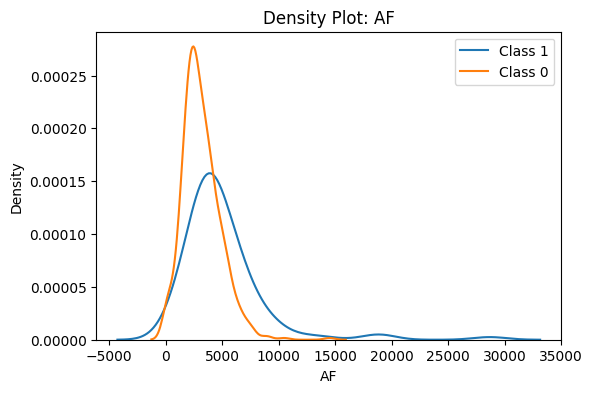

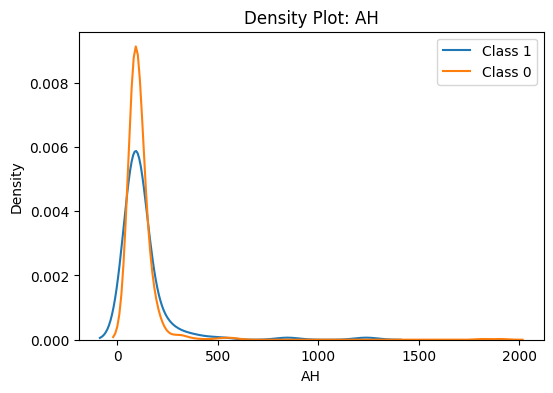

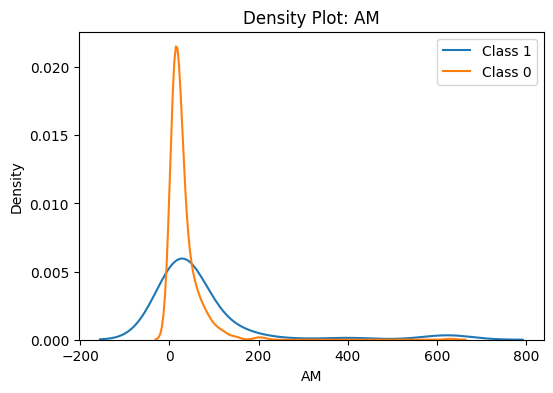

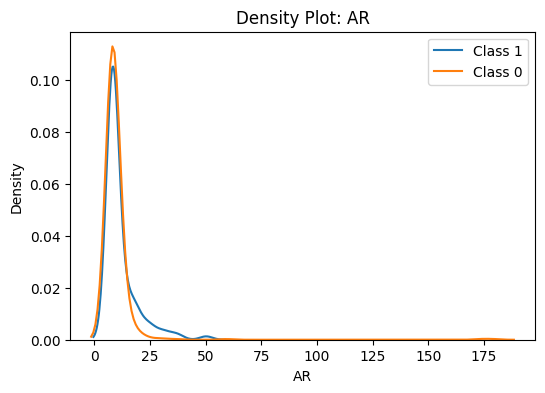

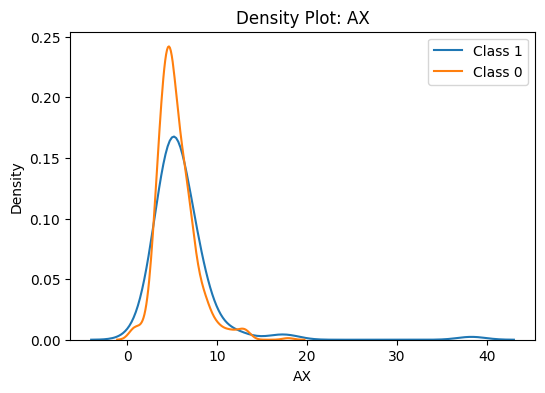

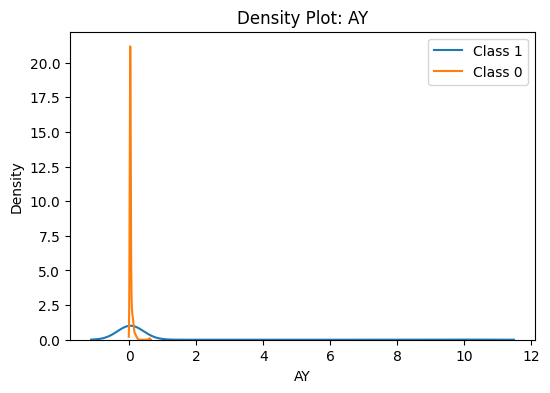

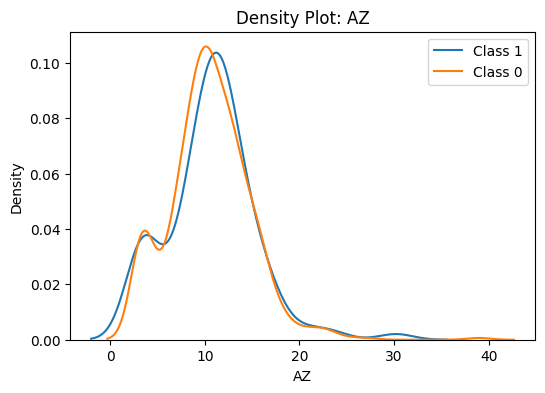

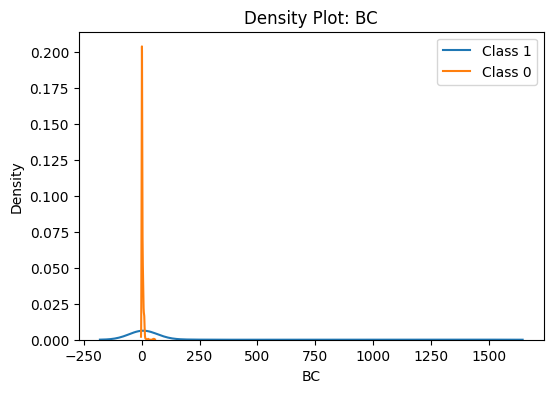

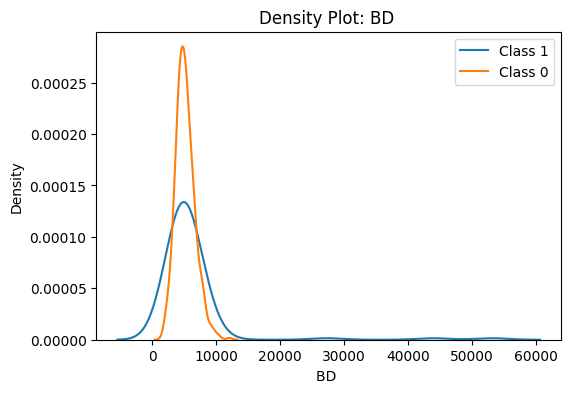

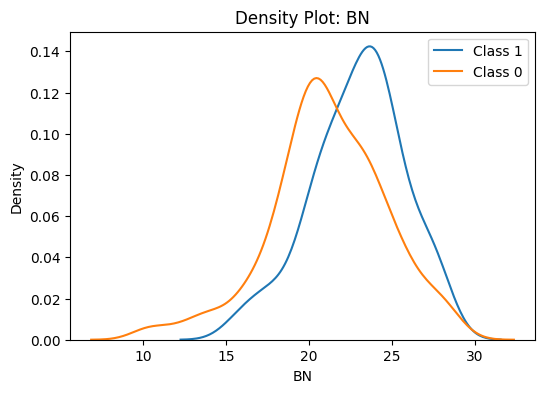

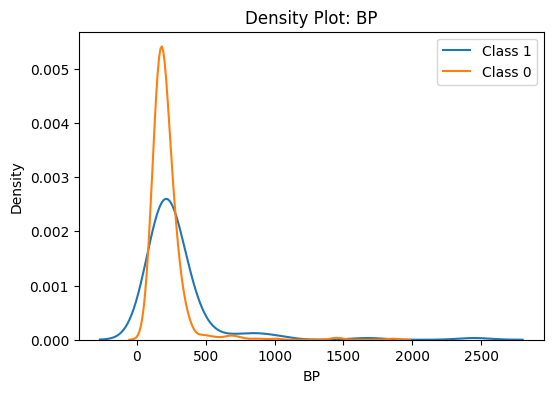

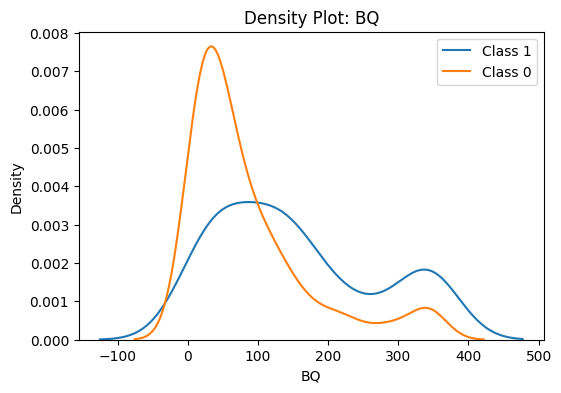

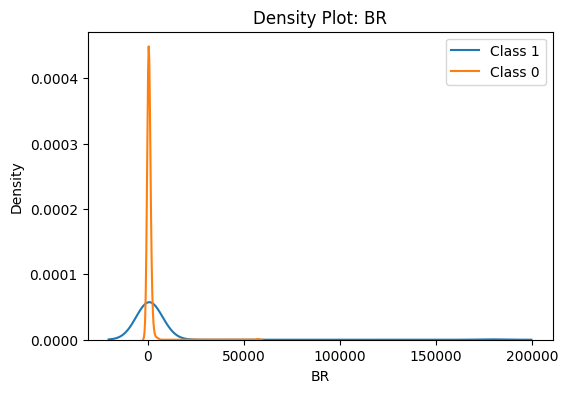

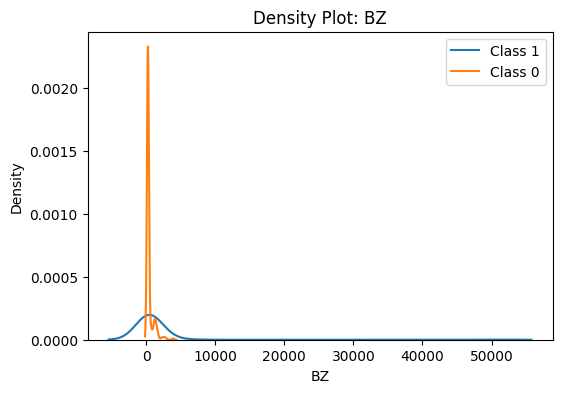

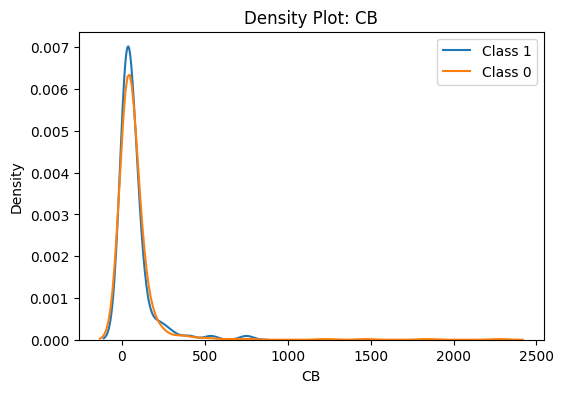

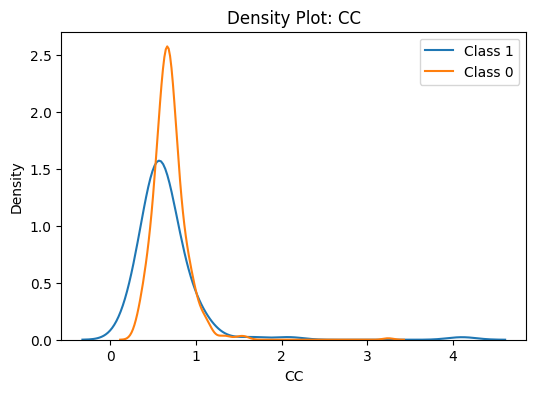

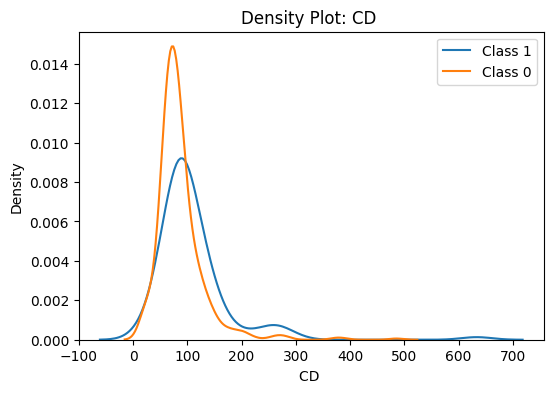

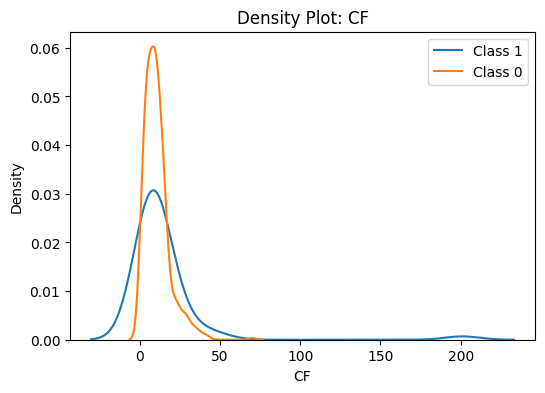

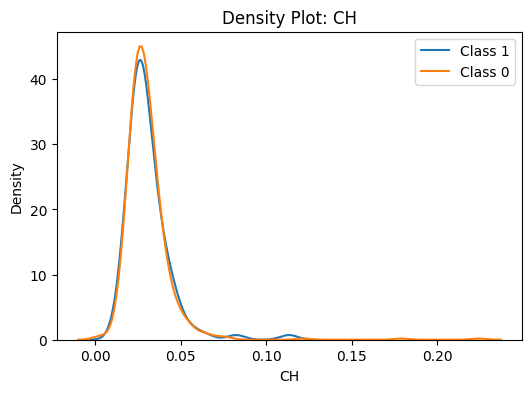

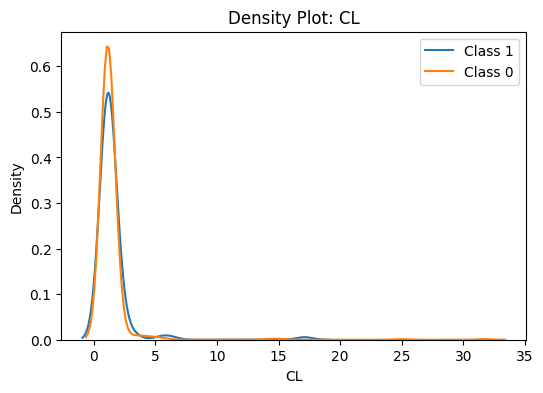

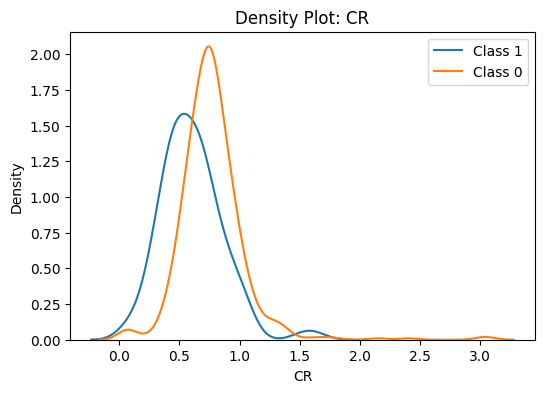

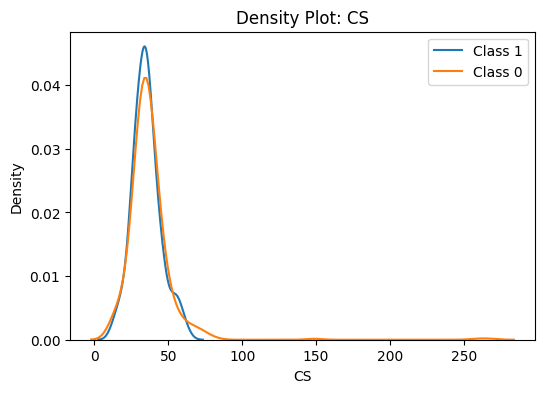

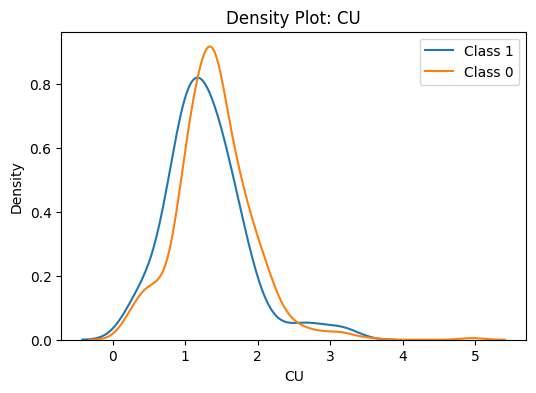

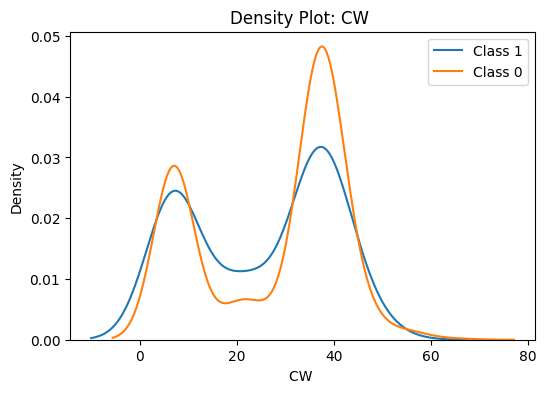

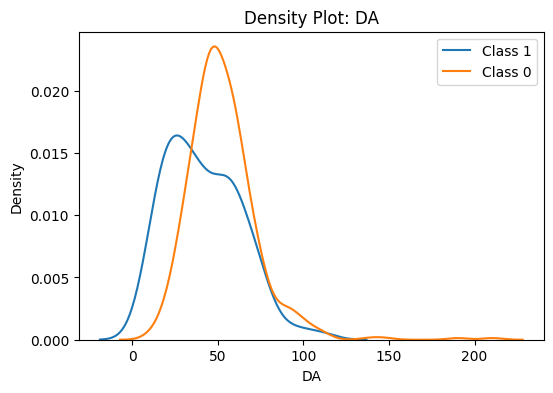

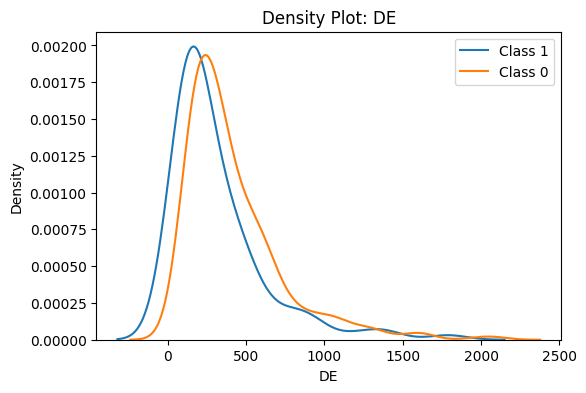

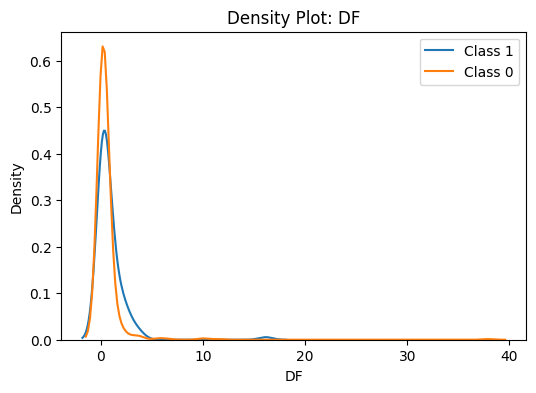

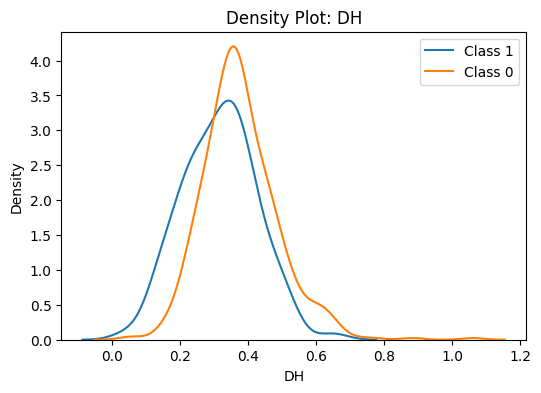

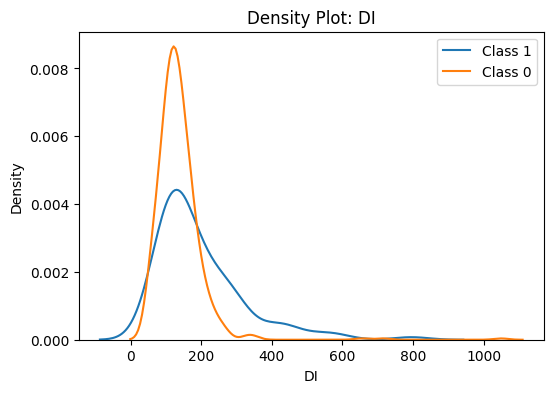

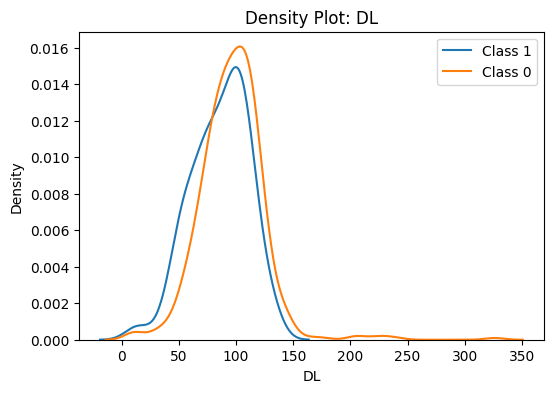

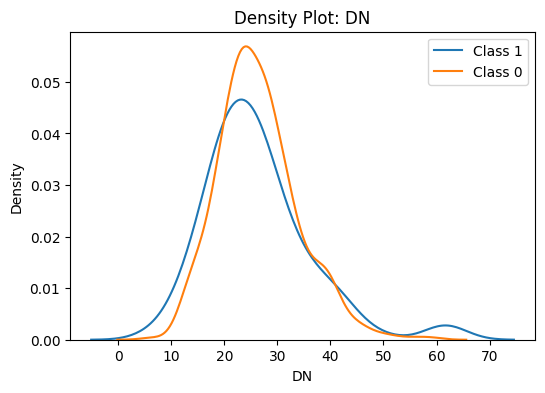

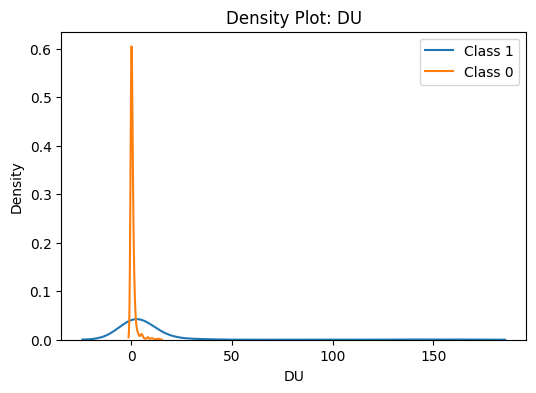

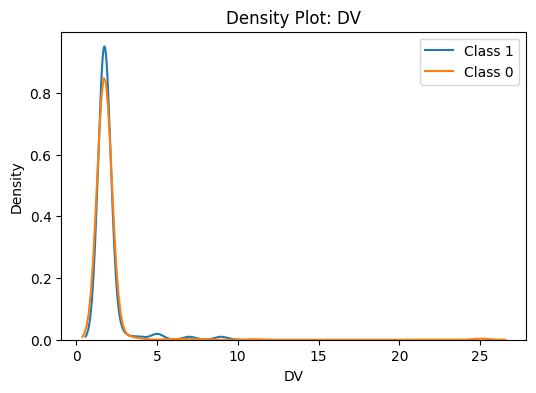

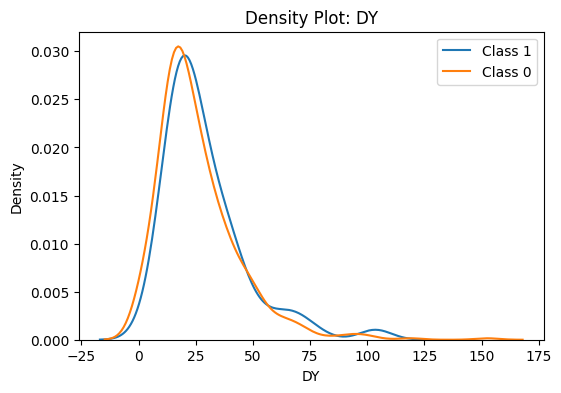

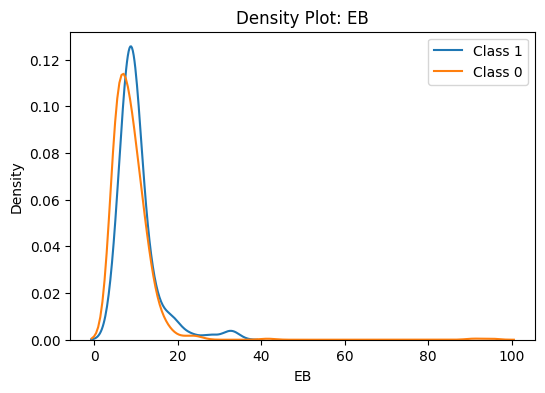

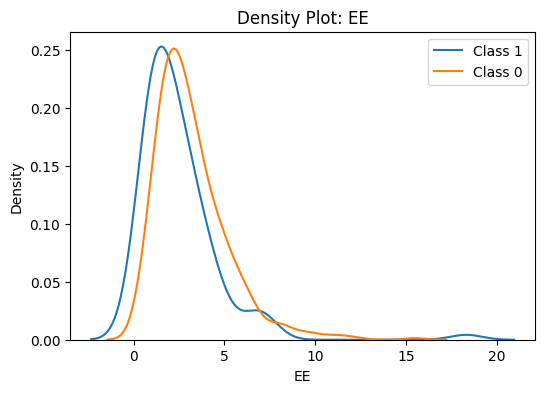

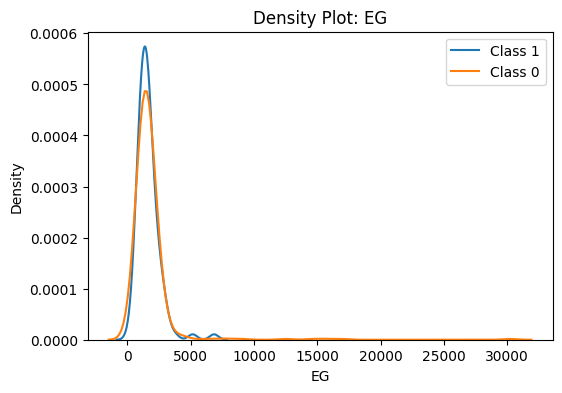

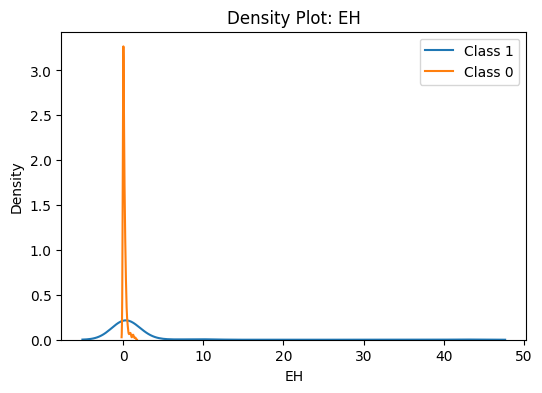

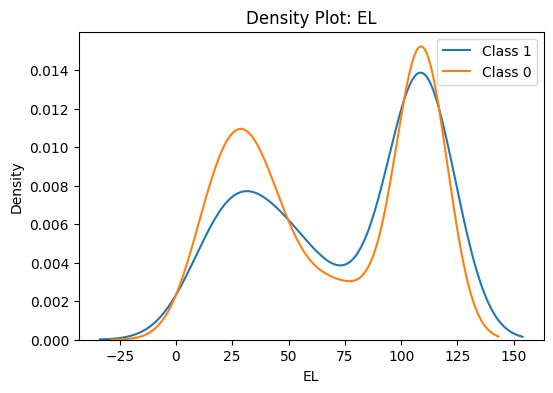

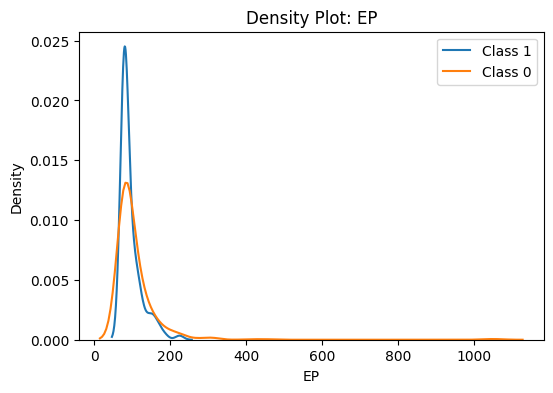

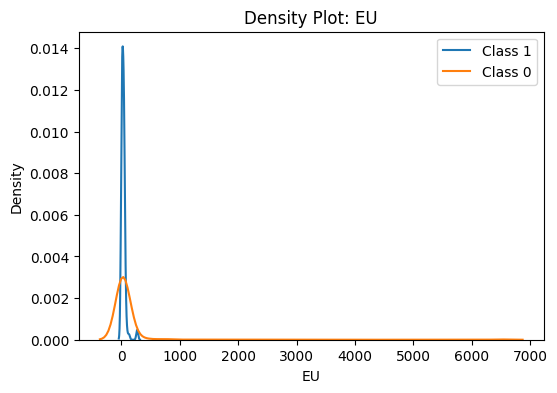

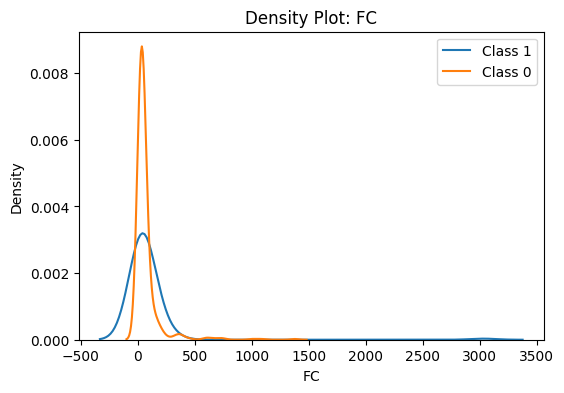

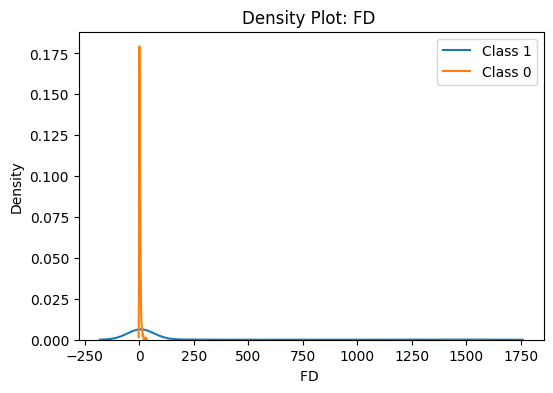

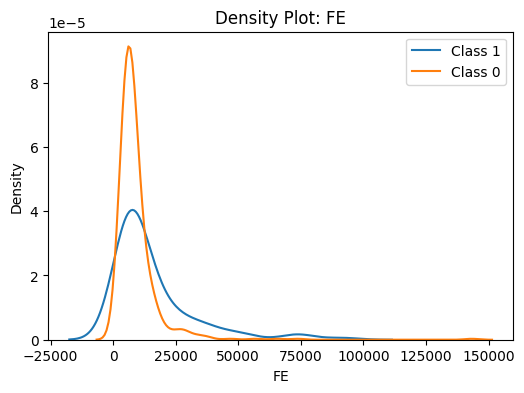

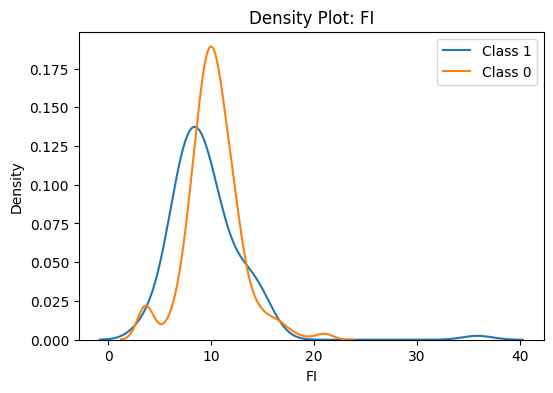

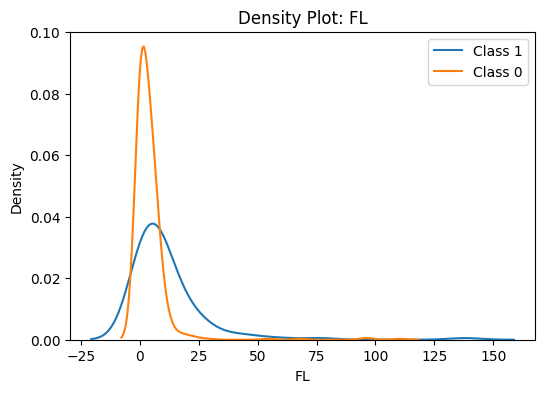

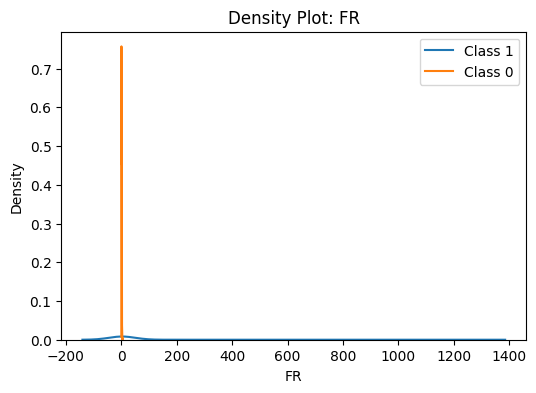

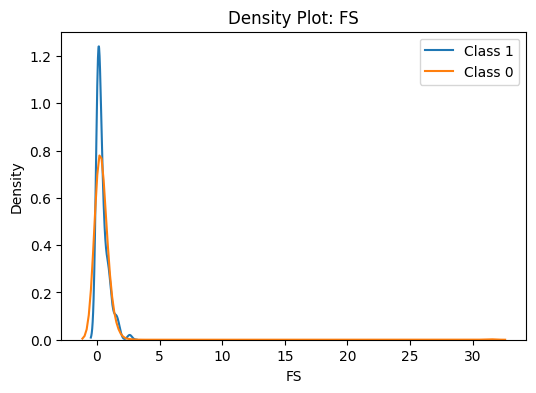

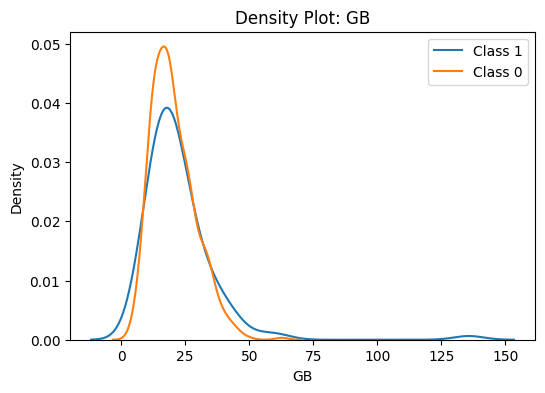

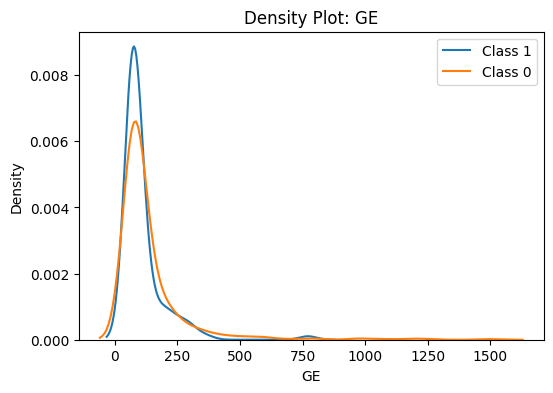

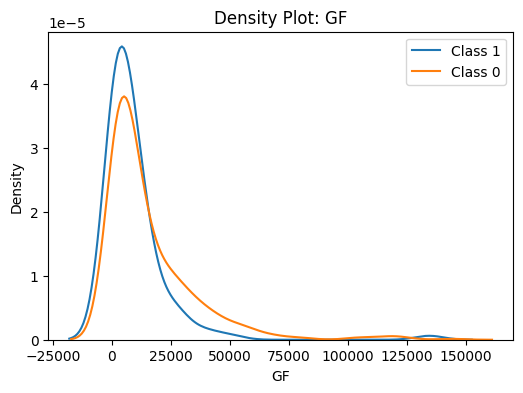

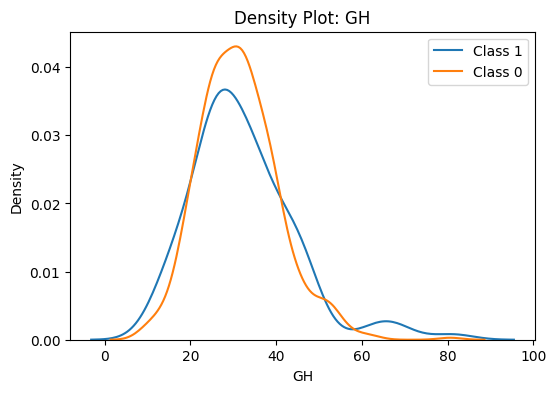

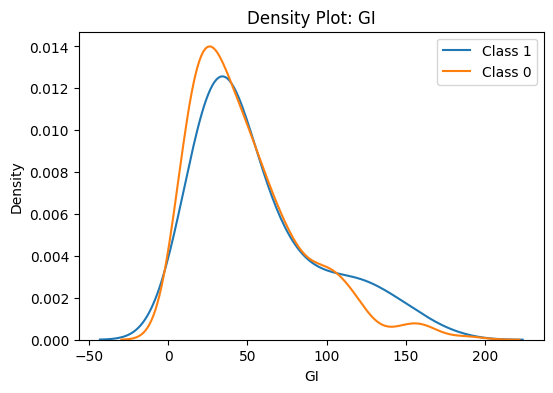

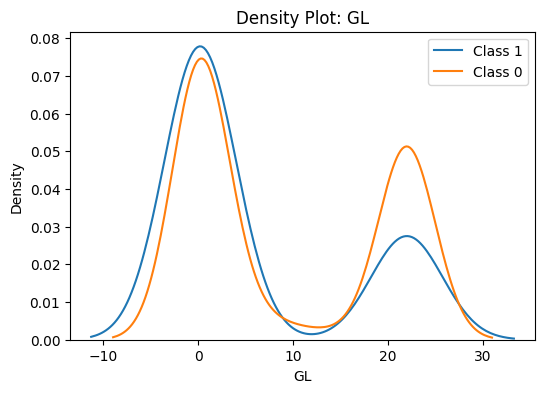

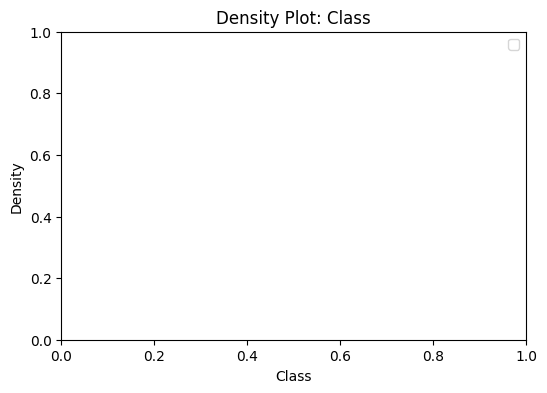

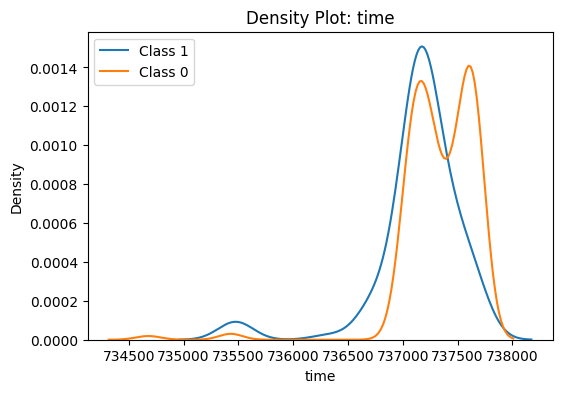

In [ ]:
# Grouping the data by 'Group'
grouped_data = df_num.groupby('Class')

# Get the unique groups
groups = df_num['Class'].unique()

# Loop through each column in the DataFrame
for column in df_num.columns[1:]:
    # Create a figure and axes for the current column
    fig, ax = plt.subplots(figsize=(6, 4))

    # Loop through each group
    for group in groups:
        # Select the data for the current group
        group_data = grouped_data.get_group(group)

        # Plot the density function for the current group
        sns.kdeplot(group_data[column], ax=ax, label=f'Class {group}')

    # Set the title and labels
    ax.set_title(f'Density Plot: {column}')
    ax.set_xlabel(column)
    ax.set_ylabel('Density')

    # Add a legend
    ax.legend()

    # Show the plot
    plt.show()

######  BQ and EL seem to be bimodal so replacing it with a mean does not represent the most likely value.  If BC is above 20, very likely to be class 1.



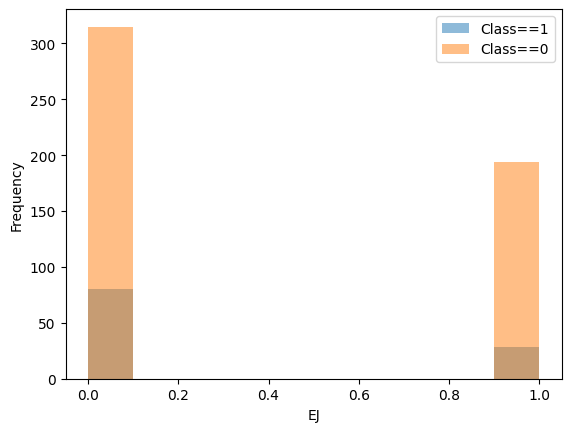

In [ ]:
#plot EJ by Class
df_cat = df[['Class','EJ']]

group_A_s = df_cat[df_cat['Class'] == 1]
group_B_s = df_cat[df_cat['Class'] == 0]

plt.hist(group_A_s['EJ'], alpha=0.5, label='Class==1')
plt.hist(group_B_s['EJ'], alpha=0.5, label='Class==0')
plt.xlabel('EJ')
plt.ylabel('Frequency')
plt.legend()
plt.show()

###### Imputing for Missing Values

Given that the distribution of some of the features are bimodal, using central tendency measures to impute for missing variables would not be appropriate. Hence, I use K-Nearest Neighbor Imputer.


In [ ]:
#KNNImputer
null_cols = ['EL', 'BQ', 'CC','CB', 'FS', 'FL', 'FC', 'DU', 'GL','time']
imputer = KNNImputer(n_neighbors=2)
df[null_cols] = imputer.fit_transform(df[null_cols])
print(df.shape)


(617, 58)


###### Data Balance

In [ ]:
# Check whether training dataset is balanced.
(df['Class'].value_counts()/len(df['Class']))*100

0    82.495948
1    17.504052
Name: Class, dtype: float64

The dataset is imbalanced with only 17% of the target classified as positive and the rest are negative. This property has to be taken into account when modelling and interpreting evaluation metrics.

Sampling Choices

Since the dataset is imbalanced, it is good to employ balancing techniques. I will attempt to use 1) Random Oversampling and 2) Synthetic Minority Over-sampling Technique (SMOTE).

In [ ]:
# Before balancing the dataset, I first separated the target and feature columns.
X = df.drop(['Class'],axis=1)
y = df.Class
y = pd.DataFrame({'Class':y})

In [ ]:
#1. Oversampling
ros =  RandomOverSampler(random_state=42)
X_ros_new, y_ros_new = ros.fit_resample(X, y)

In [ ]:
#2. SMOTE
smote =  SMOTE()
X_smote_new, y_smote_new = smote.fit_resample(X, y)

 # Training & Validation

Possible Classifier Models

Given the following characteristics of the dataset:

- Binary classification problem
- Small Dataset
- Tabular Data

I considered the following models to achieve the projects goal.



In [ ]:
# Create a list of tuples containing model name and corresponding model instance
models = [
    ("Logistic Regression", LogisticRegression()),
    ("SVM", SVC(probability=True)),
    ("KNN",KNeighborsClassifier()),
    ("Random Forest", RandomForestClassifier()),
    ("CatBoost", CatBoostClassifier(logging_level='Silent')),
    ("XGBoost", XGBClassifier()),
    ("LightGBM", LGBMClassifier()),
    ("TabPFN0", TabPFNClassifier()),
    ("TabPFN3", TabPFNClassifier( N_ensemble_configurations=64))
]

We have to download the TabPFN, as there is no checkpoint at  /usr/local/lib/python3.10/dist-packages/tabpfn/models_diff/prior_diff_real_checkpoint_n_0_epoch_100.cpkt
It has about 100MB, so this might take a moment.
Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters


Validation Metrics

In this project, I graded each model's performance by optimizing the **balanced log loss** function. I calculated other metrics for comparison.

In [ ]:
def balanced_log_loss(y_true, y_pred):

    N_0 = np.sum(1 - y_true)
    N_1 = np.sum(y_true)

    w_0 = 1 / N_0
    w_1 = 1 / N_1

    p_1 = np.clip(y_pred, 1e-15, 1 - 1e-15)
    p_0 = 1 - p_1

    log_loss_0 = -np.sum((1 - y_true) * np.log(p_0))
    log_loss_1 = -np.sum(y_true * np.log(p_1))

    balanced_log_loss = -2*(w_0 * log_loss_0 + w_1 * log_loss_1) / (w_0 + w_1)

    return balanced_log_loss/(N_0+N_1)

In [ ]:
# Create an empty DataFrame to store classification metrics
columns = ['Scenario','Model', 'Precision', 'Recall', 'F1-Score', 'AUC-ROC','Balanced Log Loss']
classification_df = pd.DataFrame(columns=columns)


Splitting Choices

I trained and validated the model based on:
1. Simple train/test split
2. Stratified KFold.

As mentioned earlier, I extracted a portion of the original train dataset for testing since the test dataset from is hidden and  cannot be downloaded.

###### Simple split dataset based on sampling choice

In [ ]:
#Oversampling
X_ros_train, X_ros_test, y_ros_train, y_ros_test = train_test_split(X_ros_new, y_ros_new, test_size=0.2, random_state=42)

#SMOTE
X_smote_train, X_smote_test, y_smote_train, y_smote_test = train_test_split(X_smote_new, y_smote_new, test_size=0.2, random_state=42)




In [ ]:
# Reset the index for each DataFrame in the list
X_ros_train = X_ros_train.reset_index(drop=True)
X_ros_test = X_ros_test.reset_index(drop=True)
y_ros_train  = y_ros_train.reset_index(drop=True)
y_ros_test = y_ros_test.reset_index(drop=True)

X_smote_train = X_smote_train.reset_index(drop=True)
X_smote_test = X_smote_test.reset_index(drop=True)
y_smote_train  = y_smote_train.reset_index(drop=True)
y_smote_test = y_smote_test.reset_index(drop=True)


In [ ]:
# Define the number of folds for k-fold cross-validation
n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)



### There are three scenarios for training and validating models.

 Scenario 1: Simple train-test splitting and Random Oversampling

In [ ]:
for model_name, model in models:
    print(f"Running {model_name}...")
    precision_scores = []
    recall_scores = []
    f1_scores = []
    auc_roc_scores =[]
    bll_scores=[]

    X_train, X_val, y_train, y_val = train_test_split(X_ros_train, y_ros_train, test_size=0.2, random_state=42)

    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    y_pred_prob = model.predict_proba(X_val)[:, 1]
    y_val2 = y_val['Class'].values
    n_pos = np.sum(y_val)

    report = classification_report(y_val, y_pred, output_dict=True)
    print(report)
    auc_roc = roc_auc_score(y_val, y_pred)
    bll = balanced_log_loss(y_val2, y_pred_prob)
    precision_scores.append(report['weighted avg']['precision'])
    recall_scores.append(report['weighted avg']['recall'])
    f1_scores.append(report['weighted avg']['f1-score'])
    auc_roc_scores.append(auc_roc)
    bll_scores.append(bll)

    # Calculate average metrics across folds
    avg_precision = np.mean(precision_scores)
    avg_recall = np.mean(recall_scores)
    avg_f1 = np.mean(f1_scores)
    avg_auc_roc = np.mean(auc_roc_scores)
    avg_bll = np.mean(bll_scores)

    # Append metrics to the DataFrame
    classification_df = classification_df.append({
        'Scenario': 'Simple Split & Oversampling',
        'Model': model_name,
        'Precision': avg_precision,
        'Recall': avg_recall,
        'F1-Score': avg_f1,
        'AUC-ROC': avg_auc_roc,
        'Balanced Log Loss' : avg_bll
    }, ignore_index=True)

Running Logistic Regression...
{'0': {'precision': 0.7362637362637363, 'recall': 0.7613636363636364, 'f1-score': 0.7486033519553074, 'support': 88}, '1': {'precision': 0.7083333333333334, 'recall': 0.68, 'f1-score': 0.6938775510204083, 'support': 75}, 'accuracy': 0.7239263803680982, 'macro avg': {'precision': 0.7222985347985349, 'recall': 0.7206818181818182, 'f1-score': 0.7212404514878579, 'support': 163}, 'weighted avg': {'precision': 0.7234123238724466, 'recall': 0.7239263803680982, 'f1-score': 0.7234227687030531, 'support': 163}}
Running SVM...
{'0': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 88}, '1': {'precision': 0.4601226993865031, 'recall': 1.0, 'f1-score': 0.6302521008403361, 'support': 75}, 'accuracy': 0.4601226993865031, 'macro avg': {'precision': 0.23006134969325154, 'recall': 0.5, 'f1-score': 0.31512605042016806, 'support': 163}, 'weighted avg': {'precision': 0.21171289849072228, 'recall': 0.4601226993865031, 'f1-score': 0.28999329793267, 'support': 163}

<ipython-input-24-725082538860>:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  classification_df = classification_df.append({
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


{'0': {'precision': 1.0, 'recall': 0.9431818181818182, 'f1-score': 0.9707602339181286, 'support': 88}, '1': {'precision': 0.9375, 'recall': 1.0, 'f1-score': 0.967741935483871, 'support': 75}, 'accuracy': 0.9693251533742331, 'macro avg': {'precision': 0.96875, 'recall': 0.9715909090909092, 'f1-score': 0.9692510847009999, 'support': 163}, 'weighted avg': {'precision': 0.9712423312883436, 'recall': 0.9693251533742331, 'f1-score': 0.9693714462950039, 'support': 163}}


<ipython-input-24-725082538860>:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  classification_df = classification_df.append({


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Scenario 2: Use Stratified Kfold

In [ ]:
for model_name, model in models:
    print(f"Running {model_name}...")
    precision_scores = []
    recall_scores = []
    f1_scores = []
    auc_roc_scores =[]
    bll_scores=[]

    for train_index, test_index in  skf.split(X_ros_train, y_ros_train):  # Replace X and y with your data
        X_train, X_val = X_ros_train.loc[train_index], X_ros_train.loc[test_index]
        y_train, y_val = y_ros_train.loc[train_index], y_ros_train.loc[test_index]

        model.fit(X_train, y_train)
        y_pred = model.predict(X_val)
        y_pred_prob = model.predict_proba(X_val)[:, 1]
        y_val2 = y_val['Class'].values
        n_pos = np.sum(y_val)


        report = classification_report(y_val, y_pred, output_dict=True)
        auc_roc = roc_auc_score(y_val, y_pred)
        bll = balanced_log_loss(y_val2, y_pred_prob)
        precision_scores.append(report['weighted avg']['precision'])
        recall_scores.append(report['weighted avg']['recall'])
        f1_scores.append(report['weighted avg']['f1-score'])
        auc_roc_scores.append(auc_roc)
        bll_scores.append(bll)

        #print(y_pred)
        #print(y_test2)


    # Calculate average metrics across folds
    avg_precision = np.mean(precision_scores)
    avg_recall = np.mean(recall_scores)
    avg_f1 = np.mean(f1_scores)
    avg_auc_roc = np.mean(auc_roc_scores)
    avg_bll = np.mean(bll_scores)

    # Append metrics to the DataFrame
    classification_df = classification_df.append({
        'Scenario': 'SKfold & Oversampling',
        'Model': model_name,
        'Precision': avg_precision,
        'Recall': avg_recall,
        'F1-Score': avg_f1,
        'AUC-ROC': avg_auc_roc,
        'Balanced Log Loss' : avg_bll
    }, ignore_index=True)



Running Logistic Regression...


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel

Running SVM...


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation

Running KNN...
Running Random Forest...


<ipython-input-46-6f75f0e08d8a>:13: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train, y_train)
<ipython-input-46-6f75f0e08d8a>:13: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train, y_train)
<ipython-input-46-6f75f0e08d8a>:13: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train, y_train)
<ipython-input-46-6f75f0e08d8a>:13: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train, y_train)
<ipython-input-46-6f75f0e08d8a>:41: FutureWarning: The frame.append method is deprecated and will be removed from pa

Running CatBoost...


<ipython-input-46-6f75f0e08d8a>:41: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  classification_df = classification_df.append({


Running XGBoost...


<ipython-input-46-6f75f0e08d8a>:41: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  classification_df = classification_df.append({
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:99: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


Running LightGBM...
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 323, number of negative: 328
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000359 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9258
[LightGBM] [Info] Number of data points in the train set: 651, number of used features: 57
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.496160 -> initscore=-0.015361
[LightGBM] [Info] Start training from score -0.015361
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with p

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:99: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:99: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:99: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:99: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

<ipython-input-46-6f75f0e08d8a>:41: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  classification_df = classification_df.append({
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn

Running TabPFN3...


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

Scenario 3: SKfold & SMOTE

In [ ]:
for model_name, model in models:
    print(f"Running {model_name}...")
    precision_scores = []
    recall_scores = []
    f1_scores = []
    auc_roc_scores =[]
    bll_scores=[]

    for train_index, val_index in  skf.split(X_smote_train, y_smote_train):  # Replace X and y with your data
        X_train, X_val = X_smote_train.loc[train_index], X_smote_train.loc[val_index]
        y_train, y_val = y_smote_train.loc[train_index], y_smote_train.loc[val_index]

        model.fit(X_train, y_train)
        y_pred = model.predict(X_val)
        y_pred_prob = model.predict_proba(X_val)[:, 1]
        y_val2 = y_val['Class'].values
        n_pos = np.sum(y_val)


        report = classification_report(y_val, y_pred, output_dict=True)
        auc_roc = roc_auc_score(y_val, y_pred)
        bll = balanced_log_loss(y_val2, y_pred_prob)
        precision_scores.append(report['weighted avg']['precision'])
        recall_scores.append(report['weighted avg']['recall'])
        f1_scores.append(report['weighted avg']['f1-score'])
        auc_roc_scores.append(auc_roc)
        bll_scores.append(bll)

        #print(y_pred)
        #print(y_test2)


    # Calculate average metrics across folds
    avg_precision = np.mean(precision_scores)
    avg_recall = np.mean(recall_scores)
    avg_f1 = np.mean(f1_scores)
    avg_auc_roc = np.mean(auc_roc_scores)
    avg_bll = np.mean(bll_scores)

    # Append metrics to the DataFrame
    classification_df = classification_df.append({
        'Scenario': 'SKfold & SMOTE',
        'Model': model_name,
        'Precision': avg_precision,
        'Recall': avg_recall,
        'F1-Score': avg_f1,
        'AUC-ROC': avg_auc_roc,
        'Balanced Log Loss' : avg_bll
    }, ignore_index=True)



Running Logistic Regression...


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel

Running SVM...


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

Running KNN...
Running Random Forest...


<ipython-input-49-33abd1eb27ba>:13: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train, y_train)
<ipython-input-49-33abd1eb27ba>:13: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train, y_train)
<ipython-input-49-33abd1eb27ba>:13: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train, y_train)
<ipython-input-49-33abd1eb27ba>:13: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train, y_train)
<ipython-input-49-33abd1eb27ba>:41: FutureWarning: The frame.append method is deprecated and will be removed from pa

Running CatBoost...


<ipython-input-49-33abd1eb27ba>:41: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  classification_df = classification_df.append({


Running XGBoost...


<ipython-input-49-33abd1eb27ba>:41: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  classification_df = classification_df.append({
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:99: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


Running LightGBM...
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 323, number of negative: 328
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000683 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11430
[LightGBM] [Info] Number of data points in the train set: 651, number of used features: 57
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.496160 -> initscore=-0.015361
[LightGBM] [Info] Start training from score -0.015361
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further s

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:99: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 323, number of negative: 328
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000618 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11428
[LightGBM] [Info] Number of data points in the train set: 651, number of used features: 57
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.496160 -> initscore=-0.015361
[LightGBM] [Info] Start training from score -0.015361
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive 

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:99: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 323, number of negative: 328
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000733 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11432
[LightGBM] [Info] Number of data points in the train set: 651, number of used features: 57
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.496160 -> initscore=-0.015361
[LightGBM] [Info] Start training from score -0.015361
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive 

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:99: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of data points in the train set: 651, number of used features: 57
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.496160 -> initscore=-0.015361
[LightGBM] [Info] Start training from score -0.015361
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:99: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)



[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

<ipython-input-49-33abd1eb27ba>:41: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  classification_df = classification_df.append({
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn

Running TabPFN3...


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

Evaluation of Models

In [ ]:
top_3_based_F1score = classification_df.nlargest(3, 'F1-Score')
top_3_based_F1score[['Scenario','Model','F1-Score']]

,Scenario,Model,F1-Score
3,Simple Split & Oversampling,Random Forest,0.981616
4,Simple Split & Oversampling,CatBoost,0.981616
17,SKfold & Oversampling,TabPFN3,0.977872


In [ ]:
top_3_based_bll = classification_df.nlargest(3, 'Balanced Log Loss')
top_3_based_bll[['Scenario','Model']]

,Scenario,Model
8,Simple Split & Oversampling,TabPFN3
17,SKfold & Oversampling,TabPFN3
7,Simple Split & Oversampling,TabPFN0


With simple split data (non-CV) and random oversampling,  TabPFN3 ranked the best model in terms  Balanced Log Loss Score and top second in F1 score.





In [ ]:
classification_df['Model2'] = classification_df['Scenario'] + '-' + classification_df['Model']

<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _BokehImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _AltairImportHook.find_spec() not found; falling back to find_module()


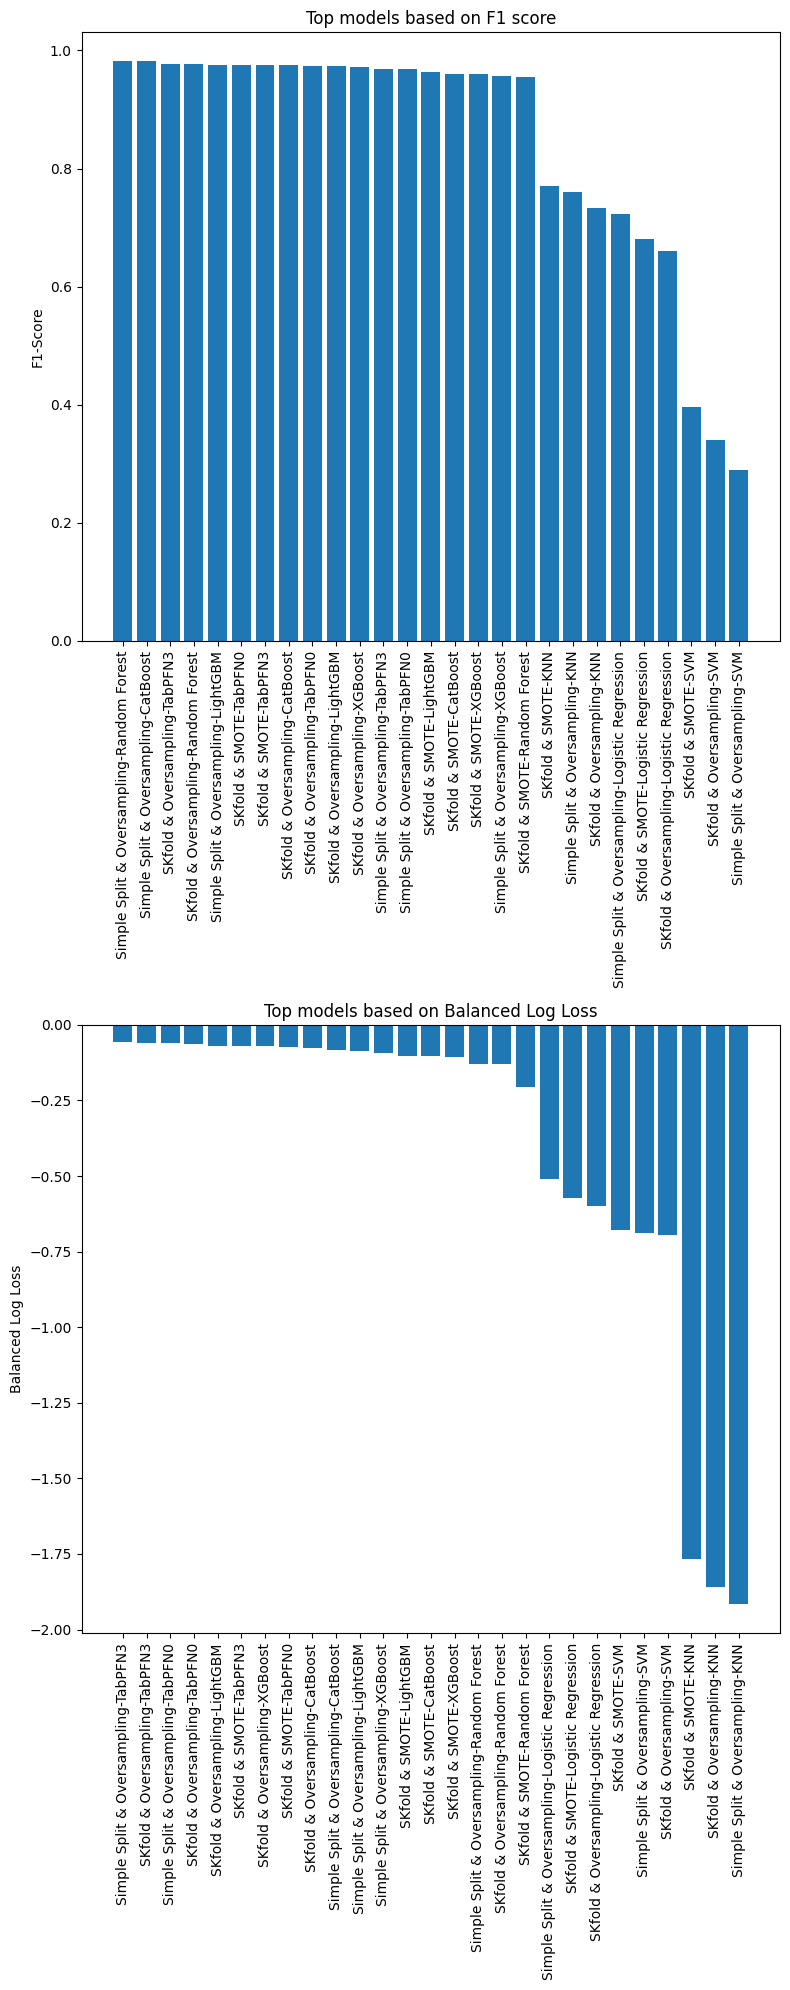

In [ ]:
df_sorted_f1 = classification_df.sort_values(by='F1-Score', ascending=False)
df_sorted_bll = classification_df.sort_values(by='Balanced Log Loss', ascending=False)


# Create three bar plots
fig, axs = plt.subplots(2, figsize=(8, 20))

# Plot for column 'b'
axs[0].bar(df_sorted_f1['Model2'], df_sorted_f1['F1-Score'])
axs[0].set_title('Top models based on F1 score')
axs[0].set_ylabel('F1-Score')
axs[0].tick_params(axis='x', labelrotation=90)  # Vertical x-axis labels


# Plot for column 'c'
axs[1].bar(df_sorted_bll['Model2'], df_sorted_bll['Balanced Log Loss'])
axs[1].set_title('Top models based on Balanced Log Loss')
axs[1].set_ylabel('Balanced Log Loss')
axs[1].tick_params(axis='x', labelrotation=90)  # Vertical x-axis labels


# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()

In [ ]:
classification_df.sort_values(by='F1-Score', ascending=False)


,Scenario,Model,Precision,Recall,F1-Score,AUC-ROC,Balanced Log Loss,Model2
3,Simple Split & Oversampling,Random Forest,0.982303,0.981595,0.981616,0.982955,-0.128440,Simple Split & Oversampling-Random Forest
4,Simple Split & Oversampling,CatBoost,0.982303,0.981595,0.981616,0.982955,-0.082796,Simple Split & Oversampling-CatBoost
17,SKfold & Oversampling,TabPFN3,0.978429,0.977876,0.977872,0.977988,-0.058556,SKfold & Oversampling-TabPFN3
12,SKfold & Oversampling,Random Forest,0.978477,0.977869,0.977863,0.977988,-0.131166,SKfold & Oversampling-Random Forest
6,Simple Split & Oversampling,LightGBM,0.976703,0.975460,0.975493,0.977273,-0.085615,Simple Split & Oversampling-LightGBM
25,SKfold & SMOTE,TabPFN0,0.975634,0.975430,0.975429,0.975504,-0.072229,SKfold & SMOTE-TabPFN0
26,SKfold & SMOTE,TabPFN3,0.975743,0.975422,0.975420,0.975519,-0.070065,SKfold & SMOTE-TabPFN3
13,SKfold & Oversampling,CatBoost,0.976755,0.975407,0.975390,0.975610,-0.075686,SKfold & Oversampling-CatBoost
16,SKfold & Oversampling,TabPFN0,0.974654,0.974203,0.974200,0.974300,-0.063605,SKfold & Oversampling-TabPFN0
15,SKfold & Oversampling,LightGBM,0.975315,0.974195,0.974178,0.974360,-0.070041,SKfold & Oversampling-LightGBM


In [ ]:
classification_df.sort_values(by='Balanced Log Loss', ascending=False)


,Scenario,Model,Precision,Recall,F1-Score,AUC-ROC,Balanced Log Loss,Model2
8,Simple Split & Oversampling,TabPFN3,0.971242,0.969325,0.969371,0.971591,-0.056742,Simple Split & Oversampling-TabPFN3
17,SKfold & Oversampling,TabPFN3,0.978429,0.977876,0.977872,0.977988,-0.058556,SKfold & Oversampling-TabPFN3
7,Simple Split & Oversampling,TabPFN0,0.971242,0.969325,0.969371,0.971591,-0.060765,Simple Split & Oversampling-TabPFN0
16,SKfold & Oversampling,TabPFN0,0.974654,0.974203,0.974200,0.974300,-0.063605,SKfold & Oversampling-TabPFN0
15,SKfold & Oversampling,LightGBM,0.975315,0.974195,0.974178,0.974360,-0.070041,SKfold & Oversampling-LightGBM
26,SKfold & SMOTE,TabPFN3,0.975743,0.975422,0.975420,0.975519,-0.070065,SKfold & SMOTE-TabPFN3
14,SKfold & Oversampling,XGBoost,0.973239,0.971719,0.971695,0.971936,-0.070194,SKfold & Oversampling-XGBoost
25,SKfold & SMOTE,TabPFN0,0.975634,0.975430,0.975429,0.975504,-0.072229,SKfold & SMOTE-TabPFN0
13,SKfold & Oversampling,CatBoost,0.976755,0.975407,0.975390,0.975610,-0.075686,SKfold & Oversampling-CatBoost
4,Simple Split & Oversampling,CatBoost,0.982303,0.981595,0.981616,0.982955,-0.082796,Simple Split & Oversampling-CatBoost


In [ ]:
grouped = classification_df.groupby('Model').mean()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-60-47f4294ae3a5>:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  grouped = classification_df.groupby('Model').mean()


In [ ]:
grouped.sort_values(by='F1-Score', ascending=False)


,Precision,Recall,F1-Score,AUC-ROC,Balanced Log Loss
Model,,,,,
TabPFN3,0.975138,0.974208,0.974221,0.975033,-0.061788
TabPFN0,0.973843,0.972986,0.973000,0.973798,-0.065533
CatBoost,0.973614,0.972554,0.972549,0.973135,-0.087357
Random Forest,0.972543,0.971734,0.971729,0.972286,-0.155526
LightGBM,0.971908,0.970931,0.970934,0.971632,-0.086160
XGBoost,0.963646,0.962743,0.962750,0.963251,-0.089818
KNN,0.767528,0.756477,0.754801,0.758794,-1.847737
Logistic Regression,0.692393,0.689692,0.687907,0.688348,-0.560475
SVM,0.424013,0.497766,0.341715,0.508683,-0.687918


In [ ]:
grouped.sort_values(by='Balanced Log Loss', ascending=False)


,Precision,Recall,F1-Score,AUC-ROC,Balanced Log Loss
Model,,,,,
TabPFN3,0.975138,0.974208,0.974221,0.975033,-0.061788
TabPFN0,0.973843,0.972986,0.973000,0.973798,-0.065533
LightGBM,0.971908,0.970931,0.970934,0.971632,-0.086160
CatBoost,0.973614,0.972554,0.972549,0.973135,-0.087357
XGBoost,0.963646,0.962743,0.962750,0.963251,-0.089818
Random Forest,0.972543,0.971734,0.971729,0.972286,-0.155526
Logistic Regression,0.692393,0.689692,0.687907,0.688348,-0.560475
SVM,0.424013,0.497766,0.341715,0.508683,-0.687918
KNN,0.767528,0.756477,0.754801,0.758794,-1.847737


On average, across all scenarious, TABPFN performs the best in terms of F1-Score and Balanced Log Loss.

In [ ]:
grouped2 = classification_df.groupby('Scenario').mean()

<ipython-input-61-7559e108e6fa>:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  grouped2 = classification_df.groupby('Scenario').mean()


In [ ]:
grouped2.sort_values(by='Balanced Log Loss', ascending=False)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Precision,Recall,F1-Score,AUC-ROC,Balanced Log Loss
Scenario,,,,,
SKfold & Oversampling,0.846631,0.861445,0.842610,0.861116,-0.402484
Simple Split & Oversampling,0.838882,0.864349,0.845384,0.870210,-0.402581
SKfold & SMOTE,0.886028,0.863903,0.848541,0.863661,-0.409039


In [ ]:
grouped2.sort_values(by='F1-Score', ascending=False)


,Precision,Recall,F1-Score,AUC-ROC,Balanced Log Loss
Scenario,,,,,
SKfold & SMOTE,0.886028,0.863903,0.848541,0.863661,-0.409039
Simple Split & Oversampling,0.838882,0.864349,0.845384,0.870210,-0.402581
SKfold & Oversampling,0.846631,0.861445,0.842610,0.861116,-0.402484


# Testing

Test only using the simple split since that is the best scenario.

In [ ]:
for model_name, model in models:
    print(f"Running {model_name}...")
    precision_scores = []
    recall_scores = []
    f1_scores = []
    auc_roc_scores =[]
    bll_scores=[]

    X_train = X_ros_train
    X_test = X_ros_test
    y_train =  y_ros_train
    y_test =  y_ros_test


    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_pred_prob = model.predict_proba(X_test)[:, 1]
    y_test2 = y_test['Class'].values
    n_pos = np.sum(y_test)


    report = classification_report(y_test, y_pred, output_dict=True)
    print(report)
    auc_roc = roc_auc_score(y_test, y_pred)
    bll = balanced_log_loss(y_test2, y_pred_prob)
    precision_scores.append(report['weighted avg']['precision'])
    recall_scores.append(report['weighted avg']['recall'])
    f1_scores.append(report['weighted avg']['f1-score'])
    auc_roc_scores.append(auc_roc)
    bll_scores.append(bll)


    # Calculate average metrics across folds
    avg_precision = np.mean(precision_scores)
    avg_recall = np.mean(recall_scores)
    avg_f1 = np.mean(f1_scores)
    avg_auc_roc = np.mean(auc_roc_scores)
    avg_bll = np.mean(bll_scores)

    # Append metrics to the DataFrame
    classification_df = classification_df.append({
        'Scenario': 'Test: Simple Split & Oversampling',
        'Model': model_name,
        'Precision': avg_precision,
        'Recall': avg_recall,
        'F1-Score': avg_f1,
        'AUC-ROC': avg_auc_roc,
        'Balanced Log Loss' : avg_bll
    }, ignore_index=True)




/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Running Logistic Regression...


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
<ipython-input-65-e0c473920c99>:41: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  classification_df = classification_df.append({
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


{'0': {'precision': 0.7641509433962265, 'recall': 0.8181818181818182, 'f1-score': 0.7902439024390244, 'support': 99}, '1': {'precision': 0.8163265306122449, 'recall': 0.7619047619047619, 'f1-score': 0.7881773399014779, 'support': 105}, 'accuracy': 0.7892156862745098, 'macro avg': {'precision': 0.7902387370042356, 'recall': 0.7900432900432901, 'f1-score': 0.7892106211702512, 'support': 204}, 'weighted avg': {'precision': 0.7910060250515301, 'recall': 0.7892156862745098, 'f1-score': 0.789180230544699, 'support': 204}}
Running SVM...
{'0': {'precision': 0.49748743718592964, 'recall': 1.0, 'f1-score': 0.6644295302013422, 'support': 99}, '1': {'precision': 1.0, 'recall': 0.047619047619047616, 'f1-score': 0.0909090909090909, 'support': 105}, 'accuracy': 0.5098039215686274, 'macro avg': {'precision': 0.7487437185929648, 'recall': 0.5238095238095238, 'f1-score': 0.3776693105552166, 'support': 204}, 'weighted avg': {'precision': 0.7561336092225834, 'recall': 0.5098039215686274, 'f1-score': 0.36

<ipython-input-65-e0c473920c99>:41: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  classification_df = classification_df.append({
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
<ipython-input-65-e0c473920c99>:41: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  classification_df = classification_df.append({
<ipython-input-65-e0c473920c99>:15: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train, y_train)


{'0': {'precision': 1.0, 'recall': 0.9797979797979798, 'f1-score': 0.989795918367347, 'support': 99}, '1': {'precision': 0.9813084112149533, 'recall': 1.0, 'f1-score': 0.9905660377358491, 'support': 105}, 'accuracy': 0.9901960784313726, 'macro avg': {'precision': 0.9906542056074766, 'recall': 0.9898989898989898, 'f1-score': 0.990180978051598, 'support': 204}, 'weighted avg': {'precision': 0.9903793293018142, 'recall': 0.9901960784313726, 'f1-score': 0.9901923033364289, 'support': 204}}
Running CatBoost...


<ipython-input-65-e0c473920c99>:41: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  classification_df = classification_df.append({


{'0': {'precision': 1.0, 'recall': 0.9494949494949495, 'f1-score': 0.9740932642487047, 'support': 99}, '1': {'precision': 0.9545454545454546, 'recall': 1.0, 'f1-score': 0.9767441860465117, 'support': 105}, 'accuracy': 0.9754901960784313, 'macro avg': {'precision': 0.9772727272727273, 'recall': 0.9747474747474747, 'f1-score': 0.9754187251476082, 'support': 204}, 'weighted avg': {'precision': 0.9766042780748664, 'recall': 0.9754901960784313, 'f1-score': 0.9754577092916935, 'support': 204}}
Running XGBoost...


<ipython-input-65-e0c473920c99>:41: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  classification_df = classification_df.append({


{'0': {'precision': 1.0, 'recall': 0.9595959595959596, 'f1-score': 0.979381443298969, 'support': 99}, '1': {'precision': 0.963302752293578, 'recall': 1.0, 'f1-score': 0.9813084112149533, 'support': 105}, 'accuracy': 0.9803921568627451, 'macro avg': {'precision': 0.981651376146789, 'recall': 0.9797979797979798, 'f1-score': 0.9803449272569611, 'support': 204}, 'weighted avg': {'precision': 0.9811117107393416, 'recall': 0.9803921568627451, 'f1-score': 0.9803732650204315, 'support': 204}}
Running LightGBM...
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 404, number of negative: 410
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000854 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11046
[LightGBM] [Info] Number of data points in the train set: 814, number of used features: 57
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.49

<ipython-input-65-e0c473920c99>:41: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  classification_df = classification_df.append({
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:99: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


{'0': {'precision': 1.0, 'recall': 0.9595959595959596, 'f1-score': 0.979381443298969, 'support': 99}, '1': {'precision': 0.963302752293578, 'recall': 1.0, 'f1-score': 0.9813084112149533, 'support': 105}, 'accuracy': 0.9803921568627451, 'macro avg': {'precision': 0.981651376146789, 'recall': 0.9797979797979798, 'f1-score': 0.9803449272569611, 'support': 204}, 'weighted avg': {'precision': 0.9811117107393416, 'recall': 0.9803921568627451, 'f1-score': 0.9803732650204315, 'support': 204}}
Running TabPFN0...


<ipython-input-65-e0c473920c99>:41: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  classification_df = classification_df.append({
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


{'0': {'precision': 1.0, 'recall': 0.98989898989899, 'f1-score': 0.9949238578680203, 'support': 99}, '1': {'precision': 0.9905660377358491, 'recall': 1.0, 'f1-score': 0.9952606635071091, 'support': 105}, 'accuracy': 0.9950980392156863, 'macro avg': {'precision': 0.9952830188679245, 'recall': 0.994949494949495, 'f1-score': 0.9950922606875647, 'support': 204}, 'weighted avg': {'precision': 0.9951442841287459, 'recall': 0.9950980392156863, 'f1-score': 0.995097213711669, 'support': 204}}
Running TabPFN3...


<ipython-input-65-e0c473920c99>:41: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  classification_df = classification_df.append({
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


{'0': {'precision': 1.0, 'recall': 0.98989898989899, 'f1-score': 0.9949238578680203, 'support': 99}, '1': {'precision': 0.9905660377358491, 'recall': 1.0, 'f1-score': 0.9952606635071091, 'support': 105}, 'accuracy': 0.9950980392156863, 'macro avg': {'precision': 0.9952830188679245, 'recall': 0.994949494949495, 'f1-score': 0.9950922606875647, 'support': 204}, 'weighted avg': {'precision': 0.9951442841287459, 'recall': 0.9950980392156863, 'f1-score': 0.995097213711669, 'support': 204}}


<ipython-input-65-e0c473920c99>:41: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  classification_df = classification_df.append({


In [ ]:
classification_df.sort_values(by='Balanced Log Loss', ascending=False)


,Scenario,Model,Precision,Recall,F1-Score,AUC-ROC,Balanced Log Loss,Model2
35,Test: Simple Split & Oversampling,TabPFN3,0.995144,0.995098,0.995097,0.994949,-0.029113,NaN
34,Test: Simple Split & Oversampling,TabPFN0,0.995144,0.995098,0.995097,0.994949,-0.029813,NaN
33,Test: Simple Split & Oversampling,LightGBM,0.981112,0.980392,0.980373,0.979798,-0.056182,NaN
8,Simple Split & Oversampling,TabPFN3,0.971242,0.969325,0.969371,0.971591,-0.056742,Simple Split & Oversampling-TabPFN3
17,SKfold & Oversampling,TabPFN3,0.978429,0.977876,0.977872,0.977988,-0.058556,SKfold & Oversampling-TabPFN3
31,Test: Simple Split & Oversampling,CatBoost,0.976604,0.975490,0.975458,0.974747,-0.059137,NaN
7,Simple Split & Oversampling,TabPFN0,0.971242,0.969325,0.969371,0.971591,-0.060765,Simple Split & Oversampling-TabPFN0
16,SKfold & Oversampling,TabPFN0,0.974654,0.974203,0.974200,0.974300,-0.063605,SKfold & Oversampling-TabPFN0
32,Test: Simple Split & Oversampling,XGBoost,0.981112,0.980392,0.980373,0.979798,-0.069295,NaN
15,SKfold & Oversampling,LightGBM,0.975315,0.974195,0.974178,0.974360,-0.070041,SKfold & Oversampling-LightGBM


# Conclusion

Given the characteristics of the dataset, TABPFN has the best performance in predicting age-related disease in terms of F1 score and balanced log loss.  The model is trained on the original dataset that was randomly resampled to balanced the data. Moreover, it was trained on 80% of the newly balanced data and tested on the rest of the 20% data. This model and scenario beat all models implemented in CV settings. It is also notable that Random Forest Model performed equally good in terms of F1 score but did not perform as well in terms of balanced log loss  (i.e. precisions and calibration).

GITHUB TEST